# Part II. Simple CNN plus land mask and season

**Author:** Eli Holmes (NOAA), Yifei Hang (UW Varanasi intern 2024), Jiarui Yu (UW Varanasi intern 2023)

[![Colab Badge](https://img.shields.io/badge/Open_in_Colab-blue?style=for-the-badge)][colab-link]
<a href="javascript:void(0);" onclick="openJupyterWidget('https://github.com/ocean-satellite-tools/mind-the-chl-gap/blob/main/book/notebooks/CHL_prediction_CNN_Part_2.ipynb');">
    <img src="https://img.shields.io/badge/Open_in_JupyterHub-orange?style=for-the-badge" alt="JupyterHub Badge">
</a> [![Download Badge](https://img.shields.io/badge/Download-grey?style=for-the-badge)][download-link]

[download-link]: https://ocean-satellite-tools.github.io/mind-the-chl-gap/_static/CHL_prediction_CNN_Part_2.ipynb
[colab-link]: https://colab.research.google.com/github/ocean-satellite-tools/mind-the-chl-gap/blob/main/book/notebooks/CHL_prediction_CNN_Part_2.ipynb
[jupyter-link]: https://nmfs-openscapes.2i2c.cloud/hub/user-redirect/lab?fromURL=https://raw.githubusercontent.com/ocean-satellite-tools/mind-the-chl-gap/main/book/notebooks/CHL_prediction_CNN_Part_2.ipynb

::: {.callout-note}
# Run this with GPU

You can run in Colab if you don't have GPU access. Click the "Open in Colab" button above. Sign in with a Google Account. You get like 100 hours of compute a month for free.

To get GPU in Colab, go to Edit > Notebook Settings  and select GPU. Then uncomment the `!pip` line below to install the needed libraries.
:::


In Part II, we will add two components to help the model: the land/ocean mask as an input (training variable) so the model can learn the land/ocean boundary and so we can use a custom loss function to tell the model not to train on the y (CHL) that is over land since those are not real data. We will also add season to the model so that the model can use different feature weightings for different times of the year.

Our new model has spatial variables, seasonal variables, and an ocean mask (categorical).

Our data is in Google Object Storage.

### Variables in the model

| Feature        | Spatial Variation       | Temporal Variation | Notes                             |
|----------------|-------------------------|--------------------|-----------------------------------|
| `sst`          | ✅ Varies by lat/lon     | ✅ Varies by time   | Numeric, normalize                |
| `so`           | ✅ Varies by lat/lon     | ✅ Varies by time   | Numeric, normalize                |
| `sin_time`     | ❌ Same across lat/lon   | ✅ Varies by time   | Cyclical, **do not normalize**    |
| `cos_time`     | ❌ Same across lat/lon   | ✅ Varies by time   | Cyclical, **do not normalize**    |
| `ocean_mask`   | ✅ Varies by lat/lon     | ❌ Static           | Binary (0=land, 1=ocean), do not normalize |
| `y` (response) | ✅ Varies by lat/lon     | ✅ Varies by time   | Numeric, maybe normalize  |


- **`sst` and `so`**: These are our core spatial-temporal features. The CNN will learn spatial filters to extract patterns over ocean and time.
  
- **`sin_time` and `cos_time`**: These introduce seasonality into our model. The CNN can learn seasonally dependent patterns, e.g., chlorophyll blooms in spring. The `sin_time` and `cos_time` features are designed to represent **seasonality** using a **cyclical encoding**. Normalizing these features (e.g., to mean 0, std 1) would **distort their circular geometry** and defeat their intended purpose.

- **`ocean_mask`**: This acts like a location-aware binary filter. It tells the CNN which pixels are land (0) vs ocean (1), which helps avoid learning patterns over invalid/land areas.

- **`y` (response)**: The model trains on this. We have logged it and it is roughly centered near 0. We need to evaluate whether our response has areas with much much higher variance than other areas. If so, we need to do some spatial normalization so our model doesn't only learn the high variance areas.


::: {.callout-note}
# Running in JupyterHub

If on the JupyterHub, shutdown kernels before you start in order to not run out of memory.

Kernel > Shutdown All Kernels
:::


## Load the libraries

In [3]:
# Uncomment this line and run if you are in Colab; leave in the !. That is part of the cmd
# !pip install zarr gcsfs --quiet

In [1]:
# --- Core data handling libraries ---
import xarray as xr       # for working with labeled multi-dimensional arrays
import numpy as np        # for numerical operations on arrays
import dask.array as da   # for lazy, parallel array operations (used in xarray backends)

# --- Plotting ---
import matplotlib.pyplot as plt  # for creating plots

In [2]:
# --- TensorFlow setup ---
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # suppress TensorFlow log spam (0=all, 3=only errors)

import tensorflow as tf  # main deep learning framework

# --- Keras (part of TensorFlow): building and training neural networks ---
from keras.models import Sequential          # lets us stack layers in a simple linear model
from keras.layers import Conv2D              # 2D convolution layer — finds spatial patterns in image-like data
from keras.layers import BatchNormalization  # stabilizes and speeds up training by normalizing activations
from keras.layers import Dropout             # randomly "drops" neurons during training to reduce overfitting
from keras.callbacks import EarlyStopping    # stops training early if validation loss doesn't improve

2025-06-19 01:43:37.121112: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-19 01:43:37.138378: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-19 01:43:37.143644: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## See what machine we are on

In [3]:
# list all the physical devices
physical_devices = tf.config.list_physical_devices()
print("All Physical Devices:", physical_devices)

# list all the available GPUs
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)

# Print infomation for available GPU if there exists any
if gpus:
    for gpu in gpus:
        details = tf.config.experimental.get_device_details(gpu)
        print("GPU Details:", details)
else:
    print("No GPU available")

All Physical Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU Details: {'compute_capability': (7, 5), 'device_name': 'Tesla T4'}


## Load data

I created the data for Part II in `Data_Prep_CNN` and uploaded to a Google storage bucket. Here I will load. The dataset goes from 1997 to 2022, however there is no salinity data after 2020.

- sst, so, sin_time, cos_time
- ocean_mask
- y (CHL)

In [3]:
# load full dataset 1997 to 2022 from Google bucket
# If loading from disk, use this dataset = xr.open_zarr("~/shared/cnn/part2.zarr")
# Replace ~/shared/cnn/part2.zarr with the actual file location
dataset = xr.open_dataset(
    "gcs://nmfs_odp_nwfsc/CB/mind_the_chl_gap/cnn_tutorial",
    engine="zarr",
    backend_kwargs={"storage_options": {"token": "anon"}},
    consolidated=True
)
dataset

<xarray.Dataset> Size: 5GB
Dimensions:     (time: 9207, lat: 149, lon: 181)
Coordinates:
  * lat         (lat) float32 596B 32.0 31.75 31.5 31.25 ... -4.5 -4.75 -5.0
  * lon         (lon) float32 724B 45.0 45.25 45.5 45.75 ... 89.5 89.75 90.0
  * time        (time) datetime64[ns] 74kB 1997-10-01 1997-10-02 ... 2022-12-31
Data variables:
    cos_time    (time, lat, lon) float32 993MB ...
    ocean_mask  (lat, lon) float32 108kB ...
    sin_time    (time, lat, lon) float32 993MB ...
    so          (time, lat, lon) float32 993MB ...
    sst         (time, lat, lon) float32 993MB ...
    topo        (lat, lon) float32 108kB ...
    y           (time, lat, lon) float32 993MB ...

## Create function for to process the data for training and testing

- Split data randomly into train, validate, and test pools
- Normalize the data using training numerical input variables (SST and salinity)
- Replace NaNs with 0.
- Return stacked Numpy arrays. Note these will "lazy" (dask arrays) if we pass in lazy dask arrays.

We need to normalize (mean zero, variance of 1) our numerical input variables but we need to compute the normalization metrics (`X_mean` and `X_std`) from the training data only. Otherwise we would have "data leakage"; information from the data we are predicting (not using for training) is used in testing or validation.

In [4]:
import numpy as np
import dask.array as da

def time_series_split(data, num_var, cat_var=None, split_ratio=(0.7, 0.2, 0.1), seed=42,
                      X_mean=None, X_std=None):
    """
    Splits time indices randomly into train/val/test. Replaces NaNs with 0s.
    Normalizes numerical variables only, using either provided or training-set mean/std.

    Parameters:
        data: xarray dataset with 'time' dimension; for memory efficiency use a dask array
        num_var: list of numerical variable names (to normalize)
        cat_var: list of categorical variable names (no normalization)
        split_ratio: tuple (train, val, test), must sum to 1.0
        seed: random seed
        X_mean, X_std: optional mean/std arrays for num_var only (shape = [n_num_vars])

    Returns:
        X, y: full input and label arrays (Dask arrays)
        X_train, y_train, X_val, y_val, X_test, y_test: split data
        X_mean, X_std: mean and std used for normalization
    """
    if cat_var is None:
        cat_var = []
    input_var = num_var + cat_var

    time_dim = "time"
    if time_dim not in data.dims:
        raise ValueError("Dataset must contain a 'time' dimension.")
    
    time_len = data.sizes[time_dim]
    rng = np.random.default_rng(seed)
    all_indices = rng.choice(time_len, size=time_len, replace=False)

    # Compute indices for splitting data into train, validate, and test
    train_end = int(split_ratio[0] * time_len)
    val_end = int((split_ratio[0] + split_ratio[1]) * time_len)
    train_idx = np.sort(all_indices[:train_end])
    val_idx = np.sort(all_indices[train_end:val_end])
    test_idx = np.sort(all_indices[val_end:])

    # Separate lists for raw (with NaNs) and pre-filled arrays
    num_arrays_raw = []
    cat_arrays = []

    for var in input_var:
        arr = data[var]
        if time_dim not in arr.dims:
            arr = arr.expand_dims({time_dim: data["time"]})
            arr = arr.broadcast_like(data["sst"])
        arr = arr.transpose(time_dim, ...)  # (time, lat, lon)
        if var in num_var:
            num_arrays_raw.append(arr.data)  # keep NaNs for now
        else:
            arr_data = da.nan_to_num(arr.data)  # fill NaNs with 0 for cat vars
            cat_arrays.append(arr_data)

    # Stack numerical variables (with NaNs still present)
    X_num_raw = da.stack(num_arrays_raw, axis=-1) if num_arrays_raw else None
    X_cat = da.stack(cat_arrays, axis=-1) if cat_arrays else None

    # Compute or apply normalization; compute mean and std from training data
    if X_num_raw is not None:
        if X_mean is not None and X_std is not None:
            X_std_safe = da.where(X_std == 0, 1.0, X_std)
        elif split_ratio[0] > 0.0:
            X_train_temp = X_num_raw[train_idx]
            X_mean = da.nanmean(X_train_temp, axis=(0, 1, 2)).compute()
            X_std = da.nanstd(X_train_temp, axis=(0, 1, 2)).compute()
            X_std_safe = da.where(X_std == 0, 1.0, X_std)
        else:
            raise ValueError("Must provide X_mean and X_std if no training data available")

        # Normalize and fill NaNs with 0 after normalization
        # All data is normalized with the X_mean and X_std from training data
        X_num = (X_num_raw - X_mean) / X_std_safe
        X_num = da.nan_to_num(X_num)
    else:
        X_num = None

    # Combine all inputs
    if X_num is not None and X_cat is not None:
        X = da.concatenate([X_num, X_cat], axis=-1)
    elif X_num is not None:
        X = X_num
    elif X_cat is not None:
        X = X_cat
    else:
        raise ValueError("No input variables provided.")

    # Prepare label (always fill NaNs in label)
    y = da.nan_to_num(data["y"].transpose(time_dim, ...).data)

    # Prep the train, val and test; return empty dask array if split ratio is 0
    X_train = X[train_idx]
    y_train = y[train_idx]

    X_val = X[val_idx]
    y_val = y[val_idx]

    X_test = X[test_idx]
    y_test = y[test_idx]

    return X, y, X_train, y_train, X_val, y_val, X_test, y_test, X_mean, X_std

## Create training data on 2020

Here we create our training and test data with 2 variables using only 2020. 70% data for training, 20% for validation and 10% for testing.

Remove days with too many NaN.

In [7]:
# Load 2020 for training
data_xr = dataset.sel(time="2020")

In [7]:
# Check how many NaNs that we have

# Broadcast to 3D: (time, lat, lon) since it is 2D now
mask_3d = data_xr["ocean_mask"].astype(bool).broadcast_like(data_xr["sst"])

# Count NaNs over ocean only
for var in ["sst", "so", "y"]:
    var_data = data_xr[var]
    ocean_nan = var_data.isnull() & mask_3d  # Use xarray's isnull()
    max_nan = ocean_nan.sum(dim=["lat", "lon"]).max().compute()
    print(f"{var}: max ocean NaNs per time step = {int(max_nan)}")

sst: max ocean NaNs per time step = 0
so: max ocean NaNs per time step = 79
y: max ocean NaNs per time step = 1602


In [8]:
nan_thresh = 0.05 * data_xr["ocean_mask"].sum().values
nan_thresh

832.0500000000001

In [9]:
mask_3d = data_xr["ocean_mask"].astype(bool).broadcast_like(data_xr["sst"])

# Count missing CHL values over ocean for each time step in CHL
chl_nan = np.isnan(data_xr["y"]) & mask_3d
chl_nan_count = chl_nan.sum(dim=["lat", "lon"])

# Set threshold: exclude days with too much missing CHL
valid_times = chl_nan_count < nan_thresh

# Apply time filtering
data_xr = data_xr.sel(time=valid_times)
print(f"Remaining days after CHL filtering: {data_xr.sizes['time']}")

Remaining days after CHL filtering: 321


### Return the stacked Numpy arrays

Technically these are dask arrays, still lazy loaded, since `data_xr` is a lazy dask array. They are not loaded into memory until we prepare them for TensorFlow with `tf.data.Dataset.from_tensor_slices()`.

In [8]:
# only normalize num_var
num_var = ['sst', 'so'] 
cat_var = ['ocean_mask', 'sin_time', 'cos_time'] 
split_ratio = [.7, .2, .1]
X, y, X_train, y_train, X_val, y_val, X_test, y_test, X_mean, X_std = time_series_split(data_xr, num_var, cat_var, split_ratio)

In [11]:
# X is still lazy loaded; dask array is lazy, not in memory yet
type(X)

dask.array.core.Array

## Create the CNN model

In [12]:
from keras.models import Sequential
from keras.layers import Input, Conv2D, BatchNormalization, Dropout

def create_model_CNN(input_shape):
    """
    Create a simple 3-layer CNN model for gridded ocean data.

    Parameters
    ----------
    input_shape : tuple
        The shape of each sample, e.g., (149, 181, 2)

    Returns
    -------
    model : keras.Model
        CNN model to predict CHL from SST and salinity
    """
    model = Sequential()

    # Input layer defines the input dimensions for the CNN
    model.add(Input(shape=input_shape))

    # Layer 1 — learns fine-scale 3x3 spatial features
    # Let the model learn 64 different patterns (filters) in the data at this layer.
    # activation relu is non-linearity
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Layer 2 — expands context to 5x5; combines fine features into larger structures
    # Reduce the number of patterns (filters) so we gradually reduce model complexity
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Layer 3 — has access to ~7x7 neighborhood; outputs CHL prediction per pixel
    # Combines all the previous layer’s features into a CHL estimate at each pixel
    # 1 response (chl) — hence, 1 prediction pixel = filter
    # linear since predicting a real continuous variable (log CHL)
    model.add(Conv2D(filters=1, kernel_size=(3, 3), padding='same', activation='linear'))

    return model

## Create a custom loss function so don't train on land

In [13]:
# Load ocean mask from dataset and convert to numpy
# Assumes ocean_mask is (lat, lon)
ocean_mask = data_xr['ocean_mask'].values.astype(np.float32)

import tensorflow as tf

# Convert once and reuse — do *not* redefine inside the loss function!
ocean_mask_tf = tf.convert_to_tensor(ocean_mask)[tf.newaxis, ..., tf.newaxis]  # shape (1, lat, lon, 1)

def masked_mae(y_true, y_pred):
    if y_true.shape.rank == 3:
        y_true = tf.expand_dims(y_true, axis=-1)
    if y_pred.shape.rank == 3:
        y_pred = tf.expand_dims(y_pred, axis=-1)

    masked_diff = tf.abs(y_true - y_pred) * ocean_mask_tf
    return tf.reduce_sum(masked_diff) / tf.reduce_sum(ocean_mask_tf)

### Let's build the model

We build a simple 3-layer CNN model. Each layer preserves the (lat, lon) shape and learns filters to extract spatial patterns. The model has ~20,000 trainable parameters, which we can see from `model.summary()`. This is small compared to huge modern CNNs (millions of parameters).

First let's look at the input shape of our data. We are passing it the whole region.

In [9]:
X_train.shape[1:]

(149, 181, 5)

Even though each convolution is local (3×3, 5×5), the input is always the full spatial extent, so the model can learn things like: “CHL is high in this particular location of the map when SST, salinity, seasonal are such and such”.  In part III, we will use smaller patches to help the model learn general patterns: “CHL is high where this type of temperature/salinity/seasonal pattern exists, no matter where on the map it occurs”.

In [14]:
# Get shape of one input sample: (lat, lon, n_features)
input_shape = X_train.shape[1:]

# Create the model using the correct input shape
model = create_model_CNN(input_shape)

# Check the model summary
# model.summary()

## Let's train the model

In [15]:
# Compile the model with Adam optimizer and mean absolute error (MAE) as both loss and evaluation metric
model.compile(
    optimizer='adam',    # Efficient and widely used optimizer
    loss=masked_mae,          # Mean Absolute Error: good for continuous data like CHL
    metrics=[masked_mae]      # Also track MAE during training/validation
)
# If you want to use mae (train over land) then use this
# model.compile(optimizer='adam',  loss='mae', metrics=['mae'])

# Set up early stopping to prevent overfitting
early_stop = EarlyStopping(
    patience=10,              # Stop if validation loss doesn't improve for 10 epochs
    restore_best_weights=True  # Revert to the model weights from the best epoch
)

# Create a TensorFlow dataset for training
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024)  # Shuffle the data (helps generalization)
train_dataset = train_dataset.batch(8)                   # Batch size = 8

# Create a TensorFlow dataset for validation (no shuffle)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(8)

# Train the model
history = model.fit(
    train_dataset,
    epochs=50,                    # Maximum number of training epochs
    validation_data=val_dataset, # Use validation data during training
    callbacks=[early_stop]       # Stop early if no improvement
)


Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 8.7936 - masked_mae: 8.7936 - val_loss: 8.3013 - val_masked_mae: 8.3013
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 4.8463 - masked_mae: 4.8463 - val_loss: 7.5331 - val_masked_mae: 7.5331
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 4.0841 - masked_mae: 4.0841 - val_loss: 6.6252 - val_masked_mae: 6.6252
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.6752 - masked_mae: 3.6752 - val_loss: 6.1853 - val_masked_mae: 6.1853
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.4060 - masked_mae: 3.4060 - val_loss: 5.8145 - val_masked_mae: 5.8145
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.2436 - masked_mae: 3.2436 - val_loss: 5.3495 - val_masked_mae: 5.3495
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.1047 - masked_mae: 3.1047 - val_loss: 5.0444 - val_masked_mae: 5.0444
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.9863 - masked_mae: 2.9

## Plot training & validation loss values

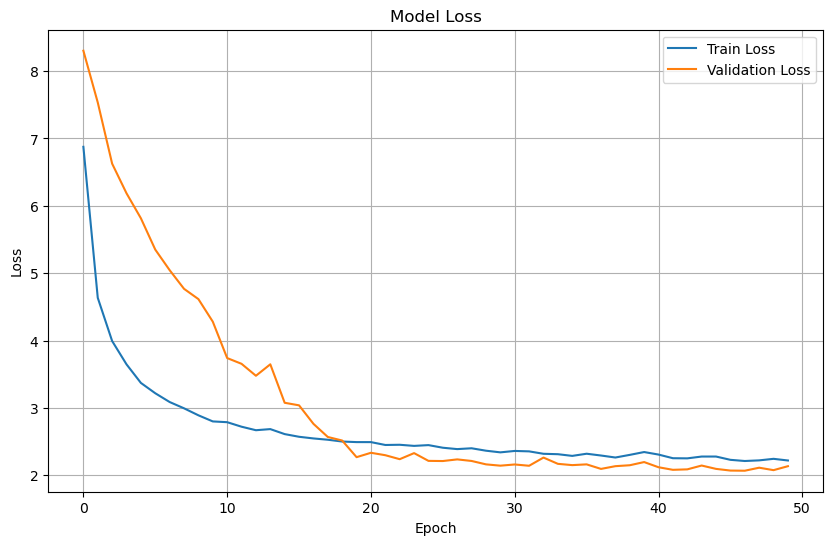

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

## Prepare test dataset

In [17]:
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(4)

# Evaluate the model on the test dataset
test_loss, test_mae = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test MAE: {test_mae}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.9987 - masked_mae: 0.9853
Test Loss: 0.9930378198623657
Test MAE: 0.9262827634811401


## Make some maps of our predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step


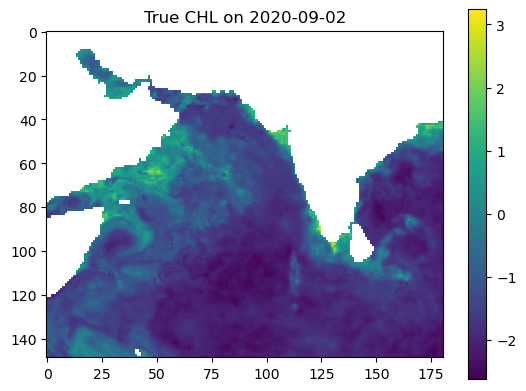

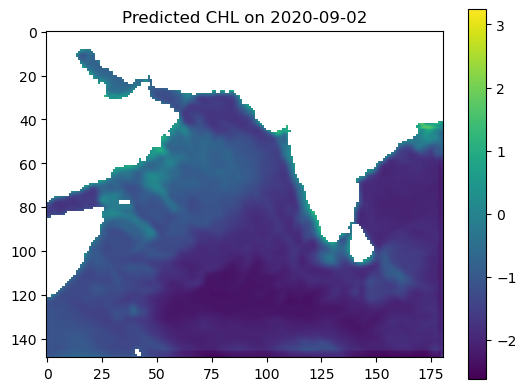

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Example: date to predict
date_to_predict = np.datetime64("2020-09-02")

# Get index of that date
available_times = data_xr["time"].values
date_index = np.where(available_times == date_to_predict)[0][0]

# Prepare input (X: shape = [time, lat, lon, n_features])
input_data = X[date_index]  # shape = (lat, lon, n_features)
input_data = np.array(input_data)     # convert to numpy

# Predict
predicted_output = model.predict(input_data[np.newaxis, ...])[0]
predicted_output = predicted_output[:, :, 0]  # shape = (lat, lon)

# True value from y
true_output = y[date_index]

# Mask land (land_mask = ~ocean)
land_mask = dataset["ocean_mask"].values == 0.0
predicted_output[land_mask] = np.nan
true_output = np.where(land_mask, np.nan, true_output)

# Plot
vmin = np.nanmin([true_output, predicted_output])
vmax = np.nanmax([true_output, predicted_output])

plt.imshow(true_output, vmin=vmin, vmax=vmax, cmap='viridis')
plt.colorbar()
plt.title(f"True CHL on {date_to_predict}")
plt.show()

plt.imshow(predicted_output, vmin=vmin, vmax=vmax, cmap='viridis')
plt.colorbar()
plt.title(f"Predicted CHL on {date_to_predict}")
plt.show()


### Let's look at all the months

First we will create a function that takes our model, the normalizing `X_mean` and `X_std`, the year to use and then makes plots of true versus predicted. We need to use `X_mean` and `X_std` from our training data. This was returned by `time_series_split()` above.

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

def plot_true_vs_predicted(data, year, model, X_mean, X_std, num_var, cat_var):
    """
    Plot true vs predicted output for first available day of each month in data_test.

    Parameters:
        data (xarray.Dataset): Contains variables 'y', 'ocean_mask', and coords 'lat', 'lon', 'time'
        year (string in format XXXX): The year to use.
        model (tf.keras.Model): Trained model with a .predict() method
        X_mean (np.ndarray): mean from the model training data (num_vars only)
        X_std (np.ndarray): std from the model training data
        num_var (np.ndarry): The variables to be standardized with `X_mean` and `X_std`
        cat_var (np.ndarry): The variables to be included in X, y but not standardized.
    """
    data_test = data.sel(time=year)
    
    # Get available time points and group by month
    available_dates = pd.to_datetime(data_test.time.values)
    monthly_dates = (
        pd.Series(available_dates)
        .groupby([available_dates.year, available_dates.month])
        .min()
        .sort_values()
    )
    n_months = len(monthly_dates)

    # lat/lon info
    lat = data_test.lat.values
    lon = data_test.lon.values
    extent = [lon.min(), lon.max(), lat.min(), lat.max()]
    flip_lat = lat[0] > lat[-1]
    land_mask = data_test["ocean_mask"].values == 0.0

    # only normalize num_var
    split_ratio = (0.0, 0.0, 1.0)
    X, y, *_ = time_series_split(data_test, num_var, cat_var, split_ratio, X_mean=X_mean, X_std=X_std)

    # Create figure and axes
    fig, axs = plt.subplots(n_months, 2, figsize=(7, 2 * n_months), constrained_layout=True)

    for i, date in enumerate(monthly_dates):
        date_index = np.where(available_dates == date)[0][0]

        # True output
        true_output = data_test['y'].sel(time=date).values
        if flip_lat:
            true_output = np.flipud(true_output)

        # Prediction
        input_data = np.array(X[date_index])
        predicted_output = model.predict(input_data[np.newaxis, ...])[0]
        predicted_output = predicted_output[:, :, 0]
        predicted_output[land_mask] = np.nan
        if flip_lat:
            predicted_output = np.flipud(predicted_output)

        # Shared color scale
        vmin = np.nanpercentile([true_output, predicted_output], 5)
        vmax = np.nanpercentile([true_output, predicted_output], 95)

        # Compute R² and RMSE
        true_flat = true_output.flatten()
        pred_flat = predicted_output.flatten()
        valid_mask = ~np.isnan(true_flat) & ~np.isnan(pred_flat)
        r2 = r2_score(true_flat[valid_mask], pred_flat[valid_mask])
        rmse = np.sqrt(np.mean((true_flat[valid_mask] - pred_flat[valid_mask]) ** 2))

        # Plot true
        axs[i, 0].imshow(true_output, origin='lower', extent=extent,
                         vmin=vmin, vmax=vmax, cmap='viridis',
                         aspect='equal')
        axs[i, 0].set_title(f"{date.strftime('%b')} — True", fontsize=10)
        axs[i, 0].axis('off')

        # Plot predicted
        axs[i, 1].imshow(predicted_output, origin='lower', extent=extent,
                         vmin=vmin, vmax=vmax, cmap='viridis',
                         aspect='equal')
        axs[i, 1].set_title(f"{date.strftime('%b')} — Pred\n$R^2$ = {r2:.2f}, RMSE = {rmse:.2f}", fontsize=10)
        axs[i, 1].axis('off')

    plt.suptitle('CHL: True vs Predicted (log scale) '+year, fontsize=16)
    plt.show()


### Make the plot

This is the first available day. Note there is missing salinity data for 2021 and 2022 so only test on 1997 to 2020. 2020 was used for training so I pick a year that is not 2020.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


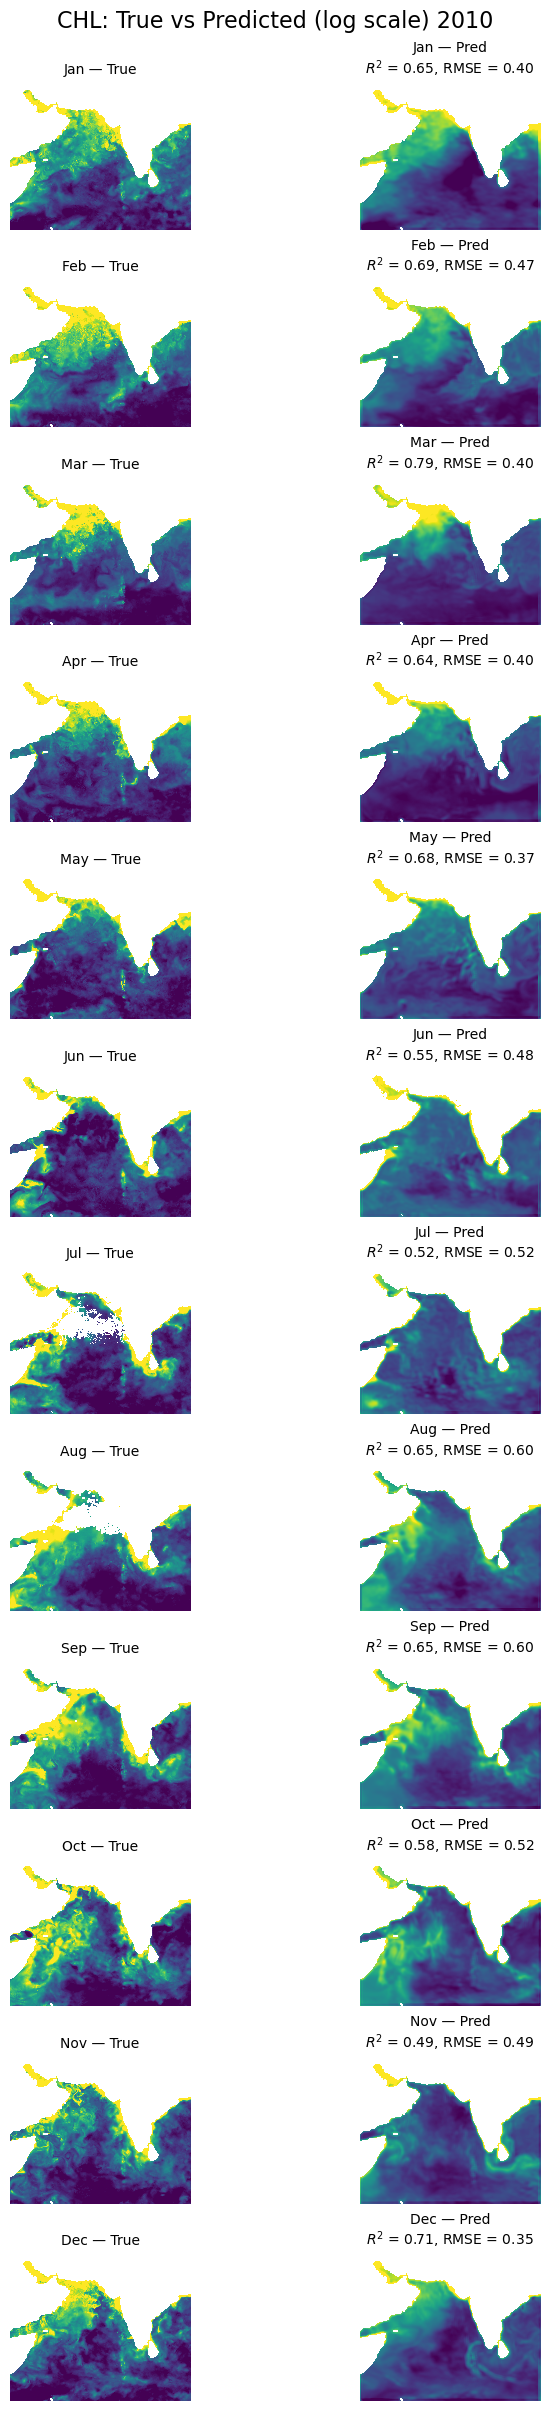

In [40]:
plot_true_vs_predicted(dataset, "2010", model, X_mean, X_std, num_var, cat_var)

## Look at R2 over years

Start by creating a function.

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error
import calendar

def plot_metric_by_month(data, years, model, X_mean, X_std, num_var, cat_var, 
                         training_year=None, metric='r2'):
    """
    Plot a selected evaluation metric (R², RMSE, MAE, or Bias) by month for each year.

    Parameters:
        data (xarray.Dataset): Contains 'y', predictors, and coordinates
        years (list of str): Years to evaluate, e.g., ['2018', '2019', '2020']
        model (tf.keras.Model): Trained model with .predict() method
        X_mean, X_std (np.ndarray): Normalization stats for num_vars
        num_var, cat_var (list of str): Variable names
        training_year (str, optional): If specified, highlights that year specially
        metric (str): One of ['r2', 'rmse', 'mae', 'bias']
    """
    assert metric in ['r2', 'rmse', 'mae', 'bias'], "Invalid metric. Choose from 'r2', 'rmse', 'mae', 'bias'."
    
    metric_by_year_month = {}

    for year in years:
        data_year = data.sel(time=year)
        dates = pd.to_datetime(data_year.time.values)

        monthly_dates = (
            pd.Series(dates)
            .groupby([dates.year, dates.month])
            .min()
            .sort_values()
        )

        split_ratio = (0.0, 0.0, 1.0)
        X, y, *_ = time_series_split(data_year, num_var, cat_var, split_ratio, X_mean=X_mean, X_std=X_std)

        metric_scores = []
        for date in monthly_dates:
            idx = np.where(dates == date)[0][0]
            true_output = data_year['y'].sel(time=date).values
            pred_input = np.array(X[idx])
            pred_output = model.predict(pred_input[np.newaxis, ...], verbose=0)[0][:, :, 0]
            pred_output[data_year["ocean_mask"].values == 0.0] = np.nan

            mask = ~np.isnan(true_output) & ~np.isnan(pred_output)
            y_true = true_output[mask].flatten()
            y_pred = pred_output[mask].flatten()

            if metric == 'r2':
                score = r2_score(y_true, y_pred)
            elif metric == 'rmse':
                score = np.sqrt(np.mean((y_true - y_pred)**2))
            elif metric == 'mae':
                score = mean_absolute_error(y_true, y_pred)
            elif metric == 'bias':
                score = np.mean(y_pred - y_true)

            metric_scores.append(score)

        metric_by_year_month[year] = (monthly_dates.dt.month.values, metric_scores)

    # Plotting
    plt.figure(figsize=(10, 5))
    for year, (months, scores) in metric_by_year_month.items():
        label = f"{year} (train)" if year == training_year else year
        style = "--" if year == training_year else "-"
        plt.plot(months, scores, style, marker='o', label=label)

    plt.xlabel("Month")
    plt.ylabel({
        'r2': "$R^2$",
        'rmse': "RMSE",
        'mae': "MAE",
        'bias': "Bias"
    }[metric])
    plt.title(f"Monthly {metric.upper()} by Year")
    plt.xticks(np.arange(1, 13), calendar.month_abbr[1:13])
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



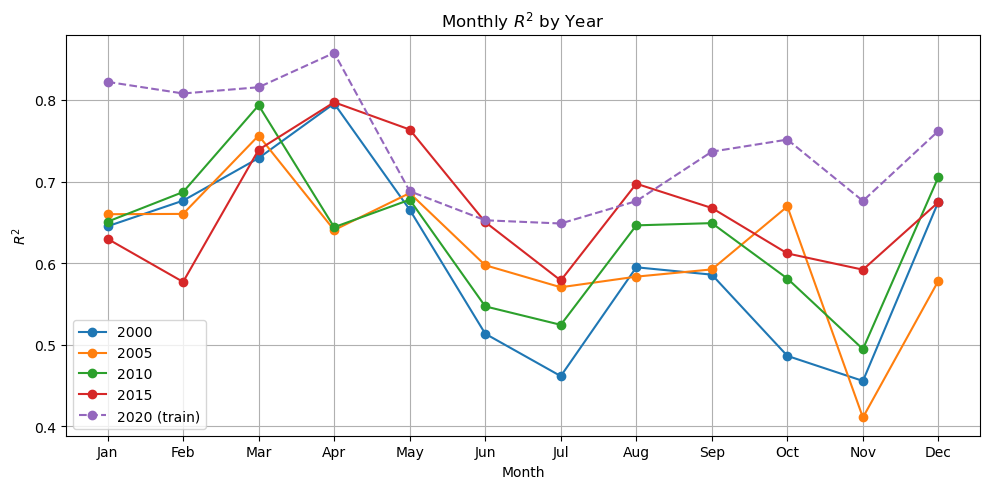

In [45]:
plot_metric_by_month(dataset, ['2000', '2005', '2010', '2015', '2020'], model, X_mean, X_std, num_var, cat_var, training_year="2020")

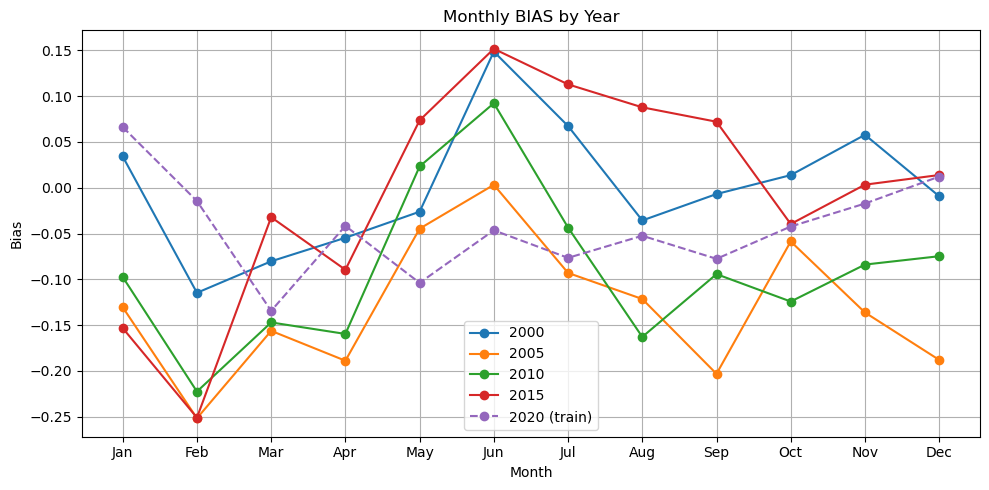

In [50]:
plot_metric_by_month(dataset, ['2000', '2005', '2010', '2015', '2020'], model, X_mean, X_std, num_var, cat_var, training_year="2020", metric="bias")

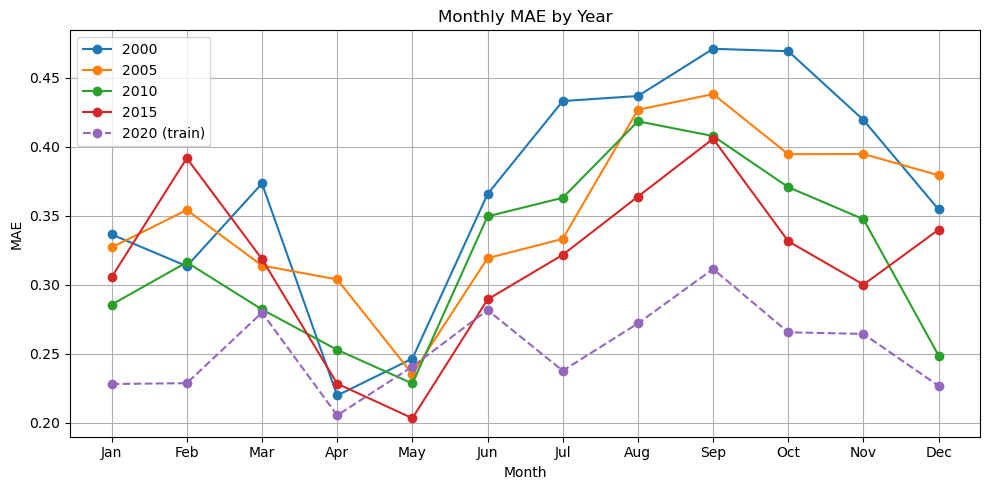

In [51]:
plot_metric_by_month(dataset, ['2000', '2005', '2010', '2015', '2020'], model, X_mean, X_std, num_var, cat_var, training_year="2020", metric="mae")

## Summary

Now we have a model that is doing ok. It still doesn't pick up the upwelling zone at the southern tip of India too well however. There is something about that area that is different and that the model is unable to learn. We should look into what drives that upwelling zone. It maybe that the relationship between SST and salinity are different there. It pokes down into a strong E-W current system.

Also the out of training years shows big variation in performance by season which suggests that we need to train on more years (more seasons).

We used the full region as the input shape for learning. What might have happened is that the model learned where and when in the region CHL tends to be high and low. But it might not have used SST and salinity at all and it might, therefore, have a hard time generalizing to other years. Note it is unlikely that this model would generalize to other regions as the SST and salinity associations are very specific to the oceanography and ocean biochemistry of the region.  

In Part III, we will try different size patches.